In [139]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tf
import torchvision.datasets as tfds
import torchvision
from torchvision.transforms import ToPILImage

In [176]:
imgfolder = ImageFolder('./COVID-19_Radiography_Database/images/',
                       transform=tf.Compose([tf.Resize(1024,1024),tf.ToTensor(),
                                            ]))

In [167]:
x = imgfolder.targets

In [168]:
d = {}
for i in x:
    if i in d.keys():
        d[i] += 1
    else:
        d[i] = 1

In [169]:
d

{0: 219, 1: 1341, 2: 1345}

In [141]:
x = list(imgfolder.class_to_idx.keys())

In [142]:
x

['COVID-19', 'NORMAL', 'Viral Pneumonia']

In [177]:
dataset_loader = torch.utils.data.DataLoader(imgfolder,
                                             batch_size=10, shuffle=True)

In [178]:
inpt, label  = next(iter(dataset_loader))

In [179]:
label

tensor([2, 2, 0, 1, 2, 1, 1, 1, 2, 2])

In [180]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

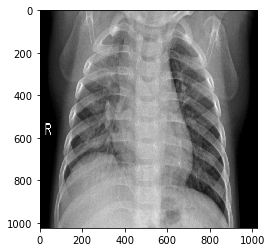

In [187]:
show(inpt[4])

In [188]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 7, stride=2, padding=3) #512
        self.conv2 = nn.Conv2d(6, 16, 3, stride=2, padding=1) #256
        self.conv3 = nn.Conv2d(16, 24, 3, stride=2, padding=1) #128
        self.conv4 = nn.Conv2d(24, 32, 3, stride=2, padding=1) #64
        self.flatten = nn.Flatten()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(512, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x)
        return x



net = Net()

In [189]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, )

In [190]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataset_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,     1] loss: 0.005
[1,   201] loss: 0.989
[2,     1] loss: 0.004
[2,   201] loss: 0.721
Finished Training


In [191]:
output = net(inpt)

/Users/justintennenbaum/opt/anaconda3/envs/facial_rec/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [197]:
for i in output:
    print(list(i).index(max(i)))
for i in label:
    print(i)

2
2
2
1
1
1
1
1
2
2
tensor(2)
tensor(2)
tensor(0)
tensor(1)
tensor(2)
tensor(1)
tensor(1)
tensor(1)
tensor(2)
tensor(2)


In [137]:
loss = criterion(output, label)

In [138]:
loss

tensor(0.9323, grad_fn=<NllLossBackward>)